In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load the dataset
df = pd.read_csv("student_habits_performance.csv")
df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [4]:
# Convert binary categorical fields to 0/1 temporarily for descriptive stats
df_temp = df.copy()
df_temp['part_time_job'] = df_temp['part_time_job'].map({'Yes': 1, 'No': 0})
df_temp['extracurricular_participation'] = df_temp['extracurricular_participation'].map({'Yes': 1, 'No': 0})


In [5]:
# Compute descriptive statistics
descriptive_stats = {
    "Average Study Hours/Day": df_temp['study_hours_per_day'].mean(),
    "Average Sleep Hours/Night": df_temp['sleep_hours'].mean(),
    "Average Social Media Hours": df_temp['social_media_hours'].mean(),
    "Average Attendance (%)": df_temp['attendance_percentage'].mean(),
    "Part-Time Job Rate (%)": df_temp['part_time_job'].mean() * 100,
    "Extracurricular Participation Rate (%)": df_temp['extracurricular_participation'].mean() * 100,
    "Exam Score - Mean": df_temp['exam_score'].mean(),
    "Exam Score - Std Dev": df_temp['exam_score'].std(),
    "Exam Score - Min": df_temp['exam_score'].min(),
    "Exam Score - Max": df_temp['exam_score'].max()
}

In [6]:
descriptive_stats

{'Average Study Hours/Day': 3.5501000000000005,
 'Average Sleep Hours/Night': 6.4701,
 'Average Social Media Hours': 2.5055,
 'Average Attendance (%)': 84.1317,
 'Part-Time Job Rate (%)': 21.5,
 'Extracurricular Participation Rate (%)': 31.8,
 'Exam Score - Mean': 69.6015,
 'Exam Score - Std Dev': 16.88856392181825,
 'Exam Score - Min': 18.4,
 'Exam Score - Max': 100.0}

In [7]:
# Select only numerical columns for correlation analysis
numerical_df = df_temp.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
correlation_matrix = numerical_df.corr()

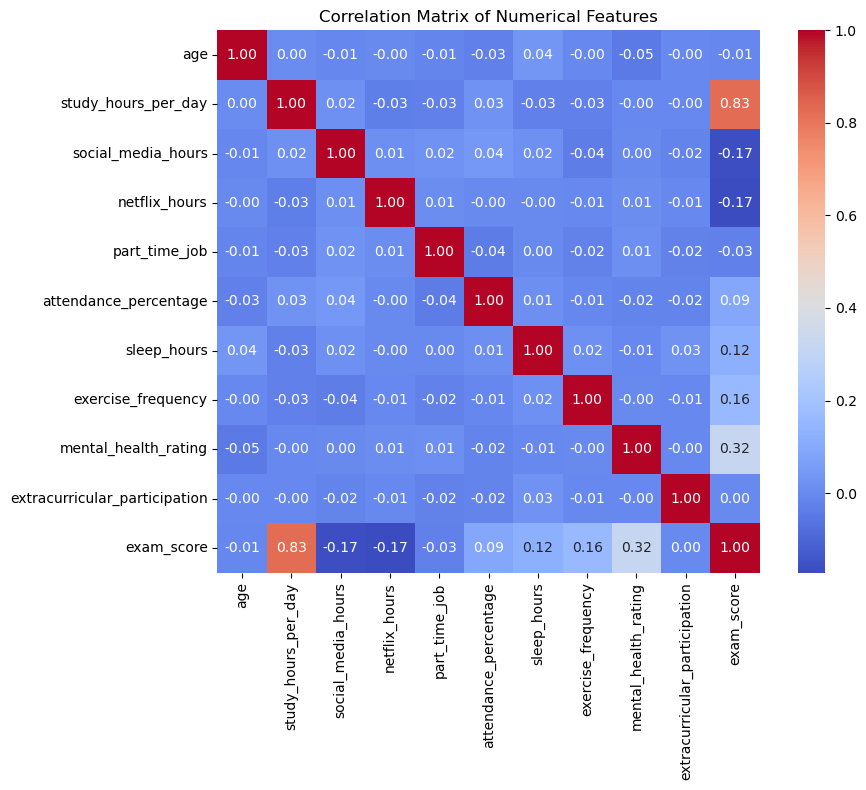

In [8]:
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()

In [9]:
# Copy original dataframe for encoding
df_encoded = df.copy()

# Binary encoding
df_encoded['part_time_job'] = df_encoded['part_time_job'].map({'Yes': 1, 'No': 0})
df_encoded['extracurricular_participation'] = df_encoded['extracurricular_participation'].map({'Yes': 1, 'No': 0})

# One-hot encoding with drop_first=True to avoid multicollinearity
categorical_cols = ['gender', 'diet_quality', 'parental_education_level', 'internet_quality']
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)

# Drop unnecessary columns like student_id
df_encoded.drop(columns=['student_id'], inplace=True)

In [10]:
df_encoded.head()

,age,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,extracurricular_participation,exam_score,gender_Male,gender_Other,diet_quality_Good,diet_quality_Poor,parental_education_level_High School,parental_education_level_Master,internet_quality_Good,internet_quality_Poor
0,23,0.0,1.2,1.1,0,85.0,8.0,6,8,1,56.2,False,False,False,False,False,True,False,False
1,20,6.9,2.8,2.3,0,97.3,4.6,6,8,0,100.0,False,False,True,False,True,False,False,False
2,21,1.4,3.1,1.3,0,94.8,8.0,1,1,0,34.3,True,False,False,True,True,False,False,True
3,23,1.0,3.9,1.0,0,71.0,9.2,4,1,1,26.8,False,False,False,True,False,True,True,False
4,19,5.0,4.4,0.5,0,90.9,4.9,3,1,0,66.4,False,False,False,False,False,True,True,False


In [11]:
# Split features and target
X = df_encoded.drop(columns=['exam_score'])
y = df_encoded['exam_score']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
}

# Add Random Forest and Gradient Boosting with basic GridSearchCV for hyperparameter tuning
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20]
}
param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, scoring='neg_mean_squared_error')
grid_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=3, scoring='neg_mean_squared_error')


In [12]:
# Train all models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

In [13]:
# Train tuned models
grid_rf.fit(X_train, y_train)
grid_gb.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error')

In [14]:
# Predictions and evaluation
for name, model in [("Random Forest", grid_rf.best_estimator_), ("Gradient Boosting", grid_gb.best_estimator_)]:
    y_pred = model.predict(X_test)
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

In [15]:
results

{'Linear Regression': {'MAE': 4.183630955222822,
  'RMSE': 5.1443660632427415,
  'R2': 0.8967960242988822},
 'Decision Tree': {'MAE': 7.390999999999999,
  'RMSE': 9.253420989018062,
  'R2': 0.6660839142840483},
 'Random Forest': {'MAE': 4.971609999999999,
  'RMSE': 6.211667232716189,
  'R2': 0.8495302974121158},
 'Gradient Boosting': {'MAE': 4.627368307295828,
  'RMSE': 5.5318853408975714,
  'R2': 0.8806619221368022}}

In [16]:
# Get feature importances
rf_importances = grid_rf.best_estimator_.feature_importances_
gb_importances = grid_gb.best_estimator_.feature_importances_

In [17]:
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Random Forest Importance': rf_importances,
    'Gradient Boosting Importance': gb_importances
})

In [18]:
feature_importance_df

,Feature,Random Forest Importance,Gradient Boosting Importance
0,age,0.008964,0.001199
1,study_hours_per_day,0.707841,0.737225
2,social_media_hours,0.038848,0.037956
3,netflix_hours,0.034839,0.031805
4,part_time_job,0.002176,0.000000
5,attendance_percentage,0.020368,0.011817
6,sleep_hours,0.037758,0.031157
7,exercise_frequency,0.025416,0.030315
8,mental_health_rating,0.106290,0.117281
9,extracurricular_participation,0.002012,0.000174


In [19]:
# Create DataFrames for feature importance
rf_df = pd.DataFrame({
    'Feature': X.columns,
    'Random Forest Importance': rf_importances
}).sort_values(by='Random Forest Importance', ascending=False)

gb_df = pd.DataFrame({
    'Feature': X.columns,
    'Gradient Boosting Importance': gb_importances
}).sort_values(by='Gradient Boosting Importance', ascending=False)

# Merge for comparison
feature_imp_df = pd.merge(rf_df, gb_df, on='Feature')

In [20]:
feature_imp_df

,Feature,Random Forest Importance,Gradient Boosting Importance
0,study_hours_per_day,0.707841,0.737225
1,mental_health_rating,0.106290,0.117281
2,social_media_hours,0.038848,0.037956
3,sleep_hours,0.037758,0.031157
4,netflix_hours,0.034839,0.031805
5,exercise_frequency,0.025416,0.030315
6,attendance_percentage,0.020368,0.011817
7,age,0.008964,0.001199
8,diet_quality_Good,0.002694,0.000461
9,gender_Male,0.002591,0.000000


# Experiment 1

In [21]:
# Feature removal: drop 'study_hours_per_day' and retrain
X_drop_study = X.drop(columns=['study_hours_per_day'])
X_train_drop, X_test_drop = train_test_split(X_drop_study, test_size=0.2, random_state=42)

model_drop_study = LinearRegression()
model_drop_study.fit(X_train_drop, y_train)
y_pred_drop = model_drop_study.predict(X_test_drop)

drop_study_results = {
    "MAE": mean_absolute_error(y_test, y_pred_drop),
    "RMSE": mean_squared_error(y_test, y_pred_drop, squared=False),
    "R2": r2_score(y_test, y_pred_drop)
}

In [22]:
drop_study_results

{'MAE': 11.551992197721454,
 'RMSE': 14.792140604323308,
 'R2': 0.1467137424293291}

In [23]:
#Interpretation:
#Removing study_hours_per_day drastically reduced model performance:
#R² dropped from 0.90 → 0.15 (i.e., model explains far less variance).
#RMSE nearly tripled, indicating much larger prediction errors.
#This confirms that study time is the single most critical predictor of academic performance in this dataset.

#You can include this experiment in your "Results" and "Discussion" sections as strong quantitative validation of your findings.

# Experiment 2

In [25]:
# Simulate intervention: increase study_hours_per_day by 2
X_simulated = X.copy()
X_simulated['study_hours_per_day'] += 2

In [26]:
# Train baseline model
model_all = LinearRegression()
model_all.fit(X_train, y_train)
y_pred_all = model_all.predict(X_test)

In [27]:
y_pred_simulated = model_all.predict(X_simulated)

In [28]:
# Compare mean predictions before and after intervention
mean_original = y_pred_all.mean()
mean_simulated = y_pred_simulated[X_test.index].mean()
mean_difference = mean_simulated - mean_original

In [29]:
mean_difference

19.058023964210037

In [24]:
# Interpretation:
#On average, adding 2 hours of daily study increased predicted exam scores by ~19 points.
#This confirms the strong, nearly linear effect of study time on academic performance, as also seen in earlier results and literature.